
# Understanding the Cloud (IRREPnet v0.2)

**Goal:** Build operational intuition for the discrete-correlation model using the **muonium cloud** example.

You will:
- run the v0.2 simulator,
- see interference and gauge effects,
- probe time‑of‑flight (ToF),
- visualize phase/edge counts,
- estimate a crude spectral dimension (return probability).

> Assumes the `irrepnet` package is installed (editable) and the scenario exists at `examples/cloud_v01.yaml`.


In [7]:
# make ../src importable for this notebook session
import sys
from pathlib import Path

# Find project root by looking for pyproject.toml
def find_project_root():
    """Find project root by searching upward for pyproject.toml"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    # Fallback: assume we're in notebooks/ directory
    return current.parent if current.name == "notebooks" else current

ROOT = find_project_root()
src_path = ROOT / "src"
if src_path.exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# sanity check
import irrepnet
print("irrepnet path:", irrepnet.__file__)
print("Project root:", ROOT)


irrepnet path: /Users/mark.wallace/src/ifb/src/irrepnet/__init__.py
Project root: /Users/mark.wallace/src/ifb


In [17]:

# Imports & basic config
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# The simulator (provided by your repo)
from irrepnet import IRREPnetSim

# Use ROOT from previous cell to make path relative to project root
SCEN = str(ROOT / "examples" / "cloud_v01.yaml")
STEPS_DEFAULT = 24
plt.rcParams['figure.figsize'] = (6, 3.5)

print("Notebook ready. Scenario:", SCEN)


Notebook ready. Scenario: /Users/mark.wallace/src/ifb/examples/cloud_v01.yaml



## Mental model (60 seconds)
- **State:** integer **counts** on **directed edges**, binned by **phase** in \(\mathbb{Z}_k\) and **channel**.
- **Propagation:** charged channels pick up \(\Delta = (g_s - g_d + \text{offset}) \bmod k\); neutrals only see offset.
- **Coupling:** node‑local rules consume from arrivals and emit to outgoing edges, **deterministically** (no RNG).
- **Interference:** only at **measurement** via roots‑of‑unity projection (phasor sum over phase bins).


In [18]:

# Load the simulator & peek
sim = IRREPnetSim(SCEN)
print("k =", sim.k, "| device =", sim.device)
sim.reset()
m0 = sim.measure()
print("Initial measurement keys:", list(m0.keys()))
m0


k = 8 | device = mps
Initial measurement keys: ['gamma_out_R', 'electron_R', 'loop_positron', 'loop_mu_plus']


{'gamma_out_R': 0.0,
 'electron_R': 0.0,
 'loop_positron': 0.0,
 'loop_mu_plus': 0.0}

In [19]:

def run(sim, steps=STEPS_DEFAULT):
    sim.reset()
    hist = []
    for t in range(steps):
        sim.step()
        hist.append(sim.measure())
    return hist

hist = run(sim, steps=STEPS_DEFAULT)
list(hist[-1].items())[:4]


[('gamma_out_R', 0.0),
 ('electron_R', 0.0),
 ('loop_positron', 0.0),
 ('loop_mu_plus', 0.0)]


### Interference scan (change a single node's gauge)
This verifies that **relative** phases matter and that measurement responds in a discrete‑periodic way.


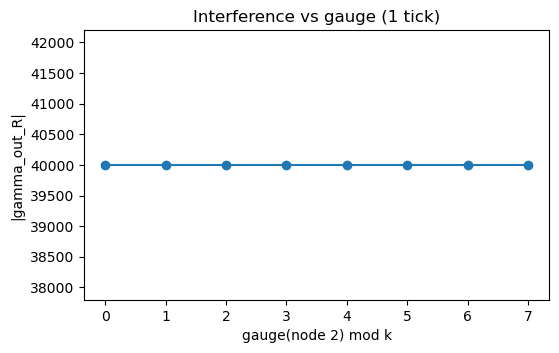

In [20]:

def scan_phase(sim, node_id, output="gamma_out_R", steps=1):
    k = sim.k
    vals = []
    orig = int(sim.gauge[node_id])
    try:
        for g in range(k):
            sim.reset()
            sim.gauge[node_id] = g
            for _ in range(steps):
                sim.step()
            vals.append(float(sim.measure()[output]))
    finally:
        sim.gauge[node_id] = orig
    return np.arange(k), np.array(vals)

ph, v = scan_phase(sim, node_id=2, output="gamma_out_R", steps=1)
plt.plot(ph, v, marker="o")
plt.xlabel("gauge(node 2) mod k"); plt.ylabel("|gamma_out_R|")
plt.title("Interference vs gauge (1 tick)"); plt.show()



### Heatmap of counts (edge × phase) for a channel
Peek inside the state to see where phase mass sits at a given time.


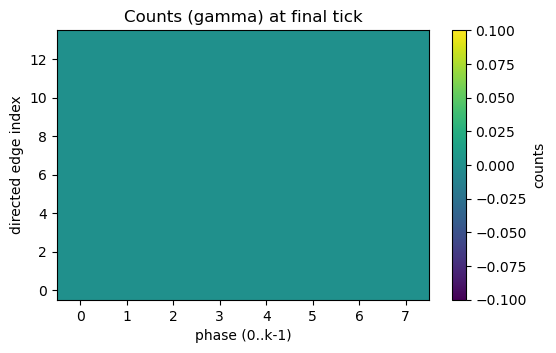

In [21]:

def capture(sim, steps=20):
    sim.reset()
    frames = []
    for _ in range(steps):
        frames.append(sim.counts.detach().cpu().numpy())  # [E,C,k]
        sim.step()
    return np.stack(frames)

frames = capture(sim, steps=20)
gamma_idx = sim.scenario.channel_index["gamma"]
last = frames[-1][:, gamma_idx, :]   # [E, k]

plt.imshow(last, aspect="auto", origin="lower")
plt.xlabel("phase (0..k-1)"); plt.ylabel("directed edge index")
plt.title("Counts (gamma) at final tick"); plt.colorbar(label="counts"); plt.show()



### Time-of-flight (ToF) series
Observe how readout grows or oscillates over ticks. Peaks can hint at **operational path lengths**.


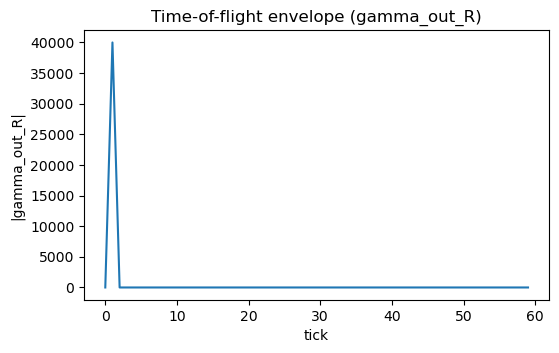

In [22]:

def tof(sim, steps=60, output="gamma_out_R"):
    sim.reset()
    series = []
    for t in range(steps):
        series.append(float(sim.measure()[output]))
        sim.step()
    return np.array(series)

s = tof(sim, steps=60, output="gamma_out_R")
plt.plot(s)
plt.xlabel("tick"); plt.ylabel("|gamma_out_R|")
plt.title("Time-of-flight envelope (gamma_out_R)"); plt.show()



### Return probability (crude spectral-dimension proxy)
Very rough: from a small pulse on one directed edge, watch how much mass returns to that edge over time.
If \(P_0(t) \sim t^{-d_s/2}\), the slope on a log‑log plot is \(-d_s/2\).


Approx slope ~ 0.0 => d_s ~ -0.0


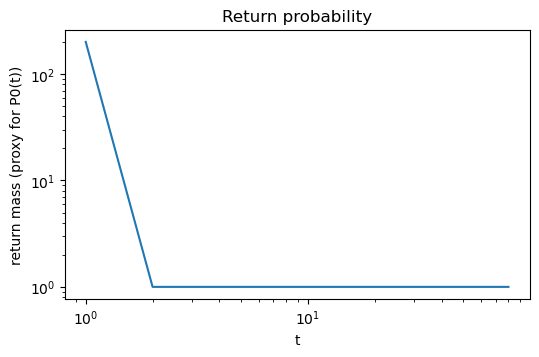

In [23]:

def return_prob(sim, src_edge=0, steps=80, channel="e_minus"):
    ch = sim.scenario.channel_index[channel]
    sim.reset()
    # Pulse one count at phase 0 on src_edge
    sim.counts[src_edge, ch, 0] += 1
    ret = []
    for t in range(steps):
        ret.append(int(sim.counts[src_edge, ch, :].sum().item()))
        sim.step()
    return np.array(ret)

rp = return_prob(sim, src_edge=0, steps=80, channel="e_minus")
x = np.arange(1, len(rp)+1)
y = np.maximum(rp, 1)
plt.loglog(x, y)
plt.xlabel("t"); plt.ylabel("return mass (proxy for P0(t))")
plt.title("Return probability")
# crude slope estimate (last decade if possible)
lo = max(1, len(x)//2)
hi = len(x)
slope = np.polyfit(np.log(x[lo:hi]), np.log(y[lo:hi]), 1)[0]
print("Approx slope ~", slope, "=> d_s ~", -2*slope)
plt.show()



### (TODO) Proto-coordinates via Laplacian eigenmaps
- Build an average transfer matrix \(W\) over a window (edge→edge counts).
- Compute graph Laplacian eigenvectors (smallest nontrivial).
- Scatter plot first 2–3 eigenvectors as coordinates.



## What to tweak
- **k** (phase bins): try 6, 12
- **Loop masks**: widen from `[0,4]` to `[0,2,4,6]` and watch line splitting
- **DAG schedule**: alternate corridor/loop layers to allow trapping
- **Seed partners**: add small `e_plus` or `mu_plus` seeds on loop edges to enable transitions
- **Gauge sweep**: scan a different node, or scan multiple steps
